## Returns 3 ds with top 20, top 10 and top 5 abundant metabolites

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from sklearn import model_selection
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead

In [2]:
#Set path to data
path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_lipids.h5ad"
# path_rna = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/RNA_concat_lipids.h5ad"

In [3]:
# Set task name and path to store
task_name  = "MSI_concat_lipids"
store_dir = "/lustre/groups/ml01/workspace/eirini.giannakoulia/hand_prep/"
# name of final data will be a combination of task_name and topN abundant metabs

In [4]:
sc.read_h5ad(path_msi)

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5618 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata_msi_full = sc.read_h5ad(path_msi)
# adata_rna_full = sc.read_h5ad(path_rna)

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Prepare MSI data

In [6]:
adata_msi_full

AnnData object with n_obs × n_vars = 5618 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Here you can subset metabolites for noise  
e.g.:  
Remove m/z below FMP10, because most likely this is noise:  
```python
adata_msi_full.var_names  
adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()

In [7]:
adata_msi_full.var_names  
adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Quality control

In [8]:
sc.pp.calculate_qc_metrics(adata_msi, inplace=True)

<Axes: xlabel='total_counts', ylabel='Count'>

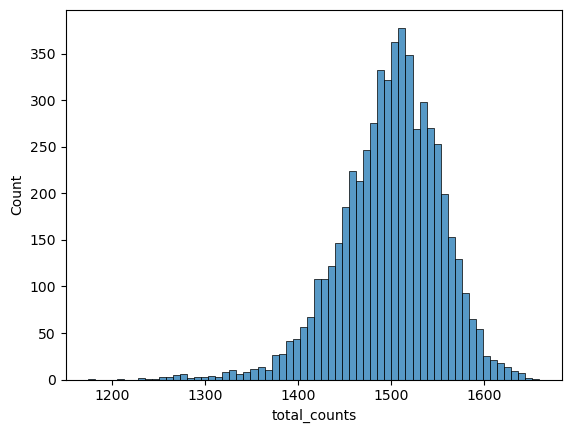

In [9]:
sns.histplot(adata_msi.obs.total_counts) #This sums all the metabolites m/z ratios for each cell

In [10]:
adata_msi.var

,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,spatialy_highly_variable,msi_highly_variable,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
288.92753500000003,False,0.545782,-1.516909,-0.200211,0,False,False,False,4977,0.518360,0.417631,11.409754,2912.145934,7.976989
289.03454999999997,False,0.823380,-1.728687,-0.287571,0,False,False,False,5527,0.800290,0.587948,1.619794,4496.029320,8.411172
289.92275500000005,False,0.730503,-1.282862,0.493938,0,False,True,False,5407,0.696756,0.528718,3.755785,3914.377394,8.272667
290.04088,True,2.644605,1.167806,1.170242,1,False,False,True,5618,2.566395,1.271555,0.000000,14418.005610,9.576302
290.041915,False,3.852103,1.828579,0.477883,0,False,False,False,5618,3.795651,1.567709,0.000000,21323.967848,9.967634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991.50214,False,0.205376,-1.133024,-0.558516,0,False,False,False,2931,0.184462,0.169288,47.828409,1036.305670,6.944382
992.560465,False,0.319687,-1.027256,0.522066,0,False,False,False,3246,0.284057,0.250024,42.221431,1595.830795,7.375776
992.614545,False,0.371143,-1.252070,0.191271,0,False,False,False,4040,0.340337,0.292921,28.088288,1912.011024,7.556434
994.56201,True,0.048320,-0.518685,0.710322,2,True,False,True,610,0.038605,0.037878,89.142043,216.882962,5.383958


<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

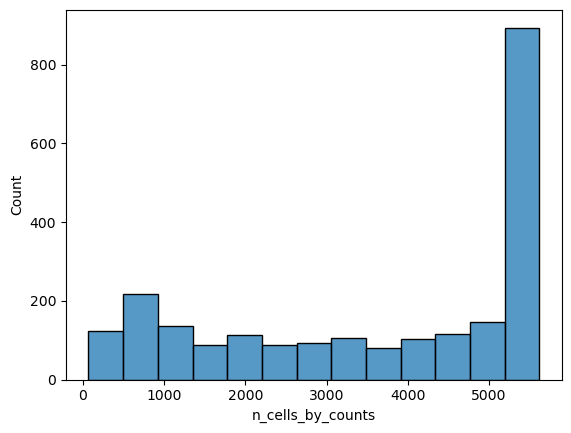

In [11]:
sns.histplot(adata_msi.var.n_cells_by_counts) #This sums all the cells for each metabolite m/z ratio
# we notice that o

In [12]:
adata_msi.var.n_cells_by_counts.describe()

count    2304.000000
mean     3681.755208
std      1938.285878
min        71.000000
25%      1858.750000
50%      4350.500000
75%      5581.250000
max      5618.000000
Name: n_cells_by_counts, dtype: float64

### Let's identify most abundant metabolites

In [18]:
adata_msi


AnnData object with n_obs × n_vars = 5618 × 2304
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors', 'moranI'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

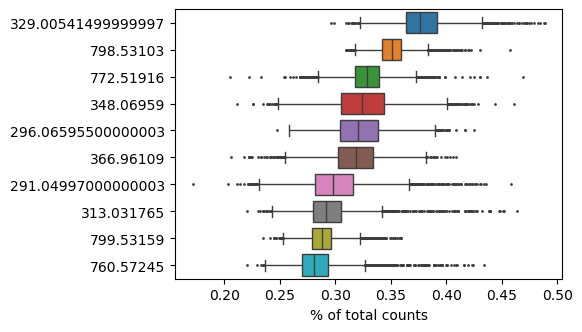

In [19]:
sc.pl.highest_expr_genes(adata_msi, n_top=10)

In [ ]:
top_30_abundant_metabolites = adata_msi.var.sort_values("total_counts", ascending=False).index[:30]


In [ ]:
top_30_abundant_metabolites

Index(['329.00541499999997', '798.53103', '772.51916', '348.06959',
       '296.06595500000003', '366.96109', '291.04997000000003', '313.031765',
       '799.53159', '760.57245', '580.0210649999999', '369.35074', '428.03476',
       '542.0648699999999', '734.563525', '291.048925', '773.52124',
       '664.108275', '422.927135', '423.980685', '617.97608',
       '580.0255850000001', '826.5699', '782.5560700000001', '290.041915',
       '330.00871', '617.9799350000001', '664.1156900000001', '406.952865',
       '524.0561849999999'],
      dtype='object')

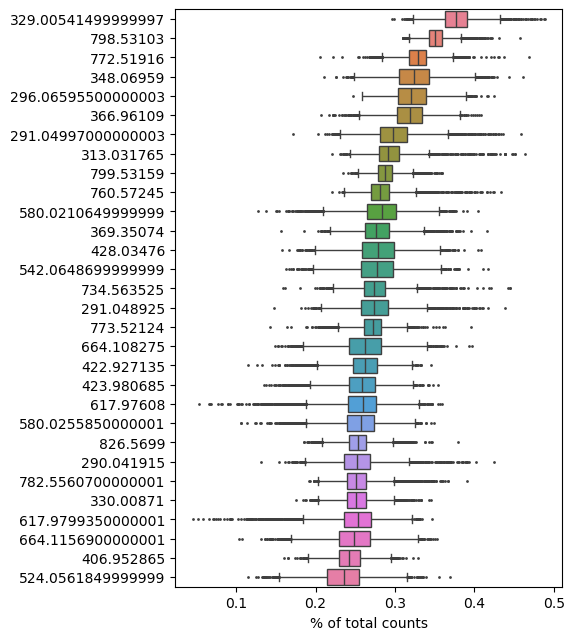

In [22]:
sc.pl.highest_expr_genes(adata_msi, n_top=30)

Mini correction for known matrix peaks, select matrix and mode


In [23]:
mz_values = adata_msi.var_names.astype(float).to_numpy()
mz_values

array([288.927535, 289.03455 , 289.922755, ..., 992.614545, 994.56201 ,
       996.51046 ])

In [ ]:
dhb_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_positive[None, :]).min(axis=1) <= 0.1])
found_peaks_str = set(map(str, found_peaks))

# dhb_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


# fmp10_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_positive[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


# fmp10_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


In [34]:
found_peaks_str

set()

In [ ]:
top_30_abundant_metabolites

Index(['329.00541499999997', '798.53103', '772.51916', '348.06959',
       '296.06595500000003', '366.96109', '291.04997000000003', '313.031765',
       '799.53159', '760.57245', '580.0210649999999', '369.35074', '428.03476',
       '542.0648699999999', '734.563525', '291.048925', '773.52124',
       '664.108275', '422.927135', '423.980685', '617.97608',
       '580.0255850000001', '826.5699', '782.5560700000001', '290.041915',
       '330.00871', '617.9799350000001', '664.1156900000001', '406.952865',
       '524.0561849999999'],
      dtype='object')

In [ ]:
top_30_abundant_filtered = [mz for mz in top_30_abundant_metabolites if mz not in found_peaks_str]
top_30_abundant_filtered

['329.00541499999997',
 '798.53103',
 '772.51916',
 '348.06959',
 '296.06595500000003',
 '366.96109',
 '291.04997000000003',
 '313.031765',
 '799.53159',
 '760.57245',
 '580.0210649999999',
 '369.35074',
 '428.03476',
 '542.0648699999999',
 '734.563525',
 '291.048925',
 '773.52124',
 '664.108275',
 '422.927135',
 '423.980685',
 '617.97608',
 '580.0255850000001',
 '826.5699',
 '782.5560700000001',
 '290.041915',
 '330.00871',
 '617.9799350000001',
 '664.1156900000001',
 '406.952865',
 '524.0561849999999']

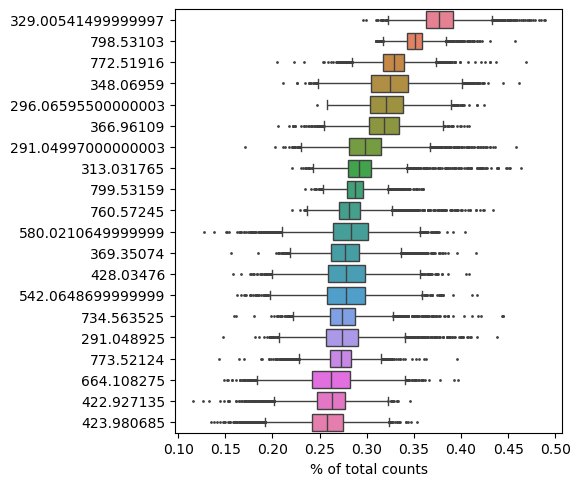

In [28]:
sc.pl.highest_expr_genes(adata_msi, n_top=20)


In [ ]:
top_20_abundant_metabolites = top_30_abundant_filtered[:20]
adata_msi_top20_abundant = adata_msi[:, adata_msi.var_names.isin(top_20_abundant_metabolites)].copy()
top_10_abundant_metabolites = top_30_abundant_filtered[:10]
adata_msi_top10_abundant = adata_msi[:, adata_msi.var_names.isin(top_10_abundant_metabolites)].copy()
top_5_abundant_metabolites = top_30_abundant_filtered[:5]
adata_msi_top5_abundant = adata_msi[:, adata_msi.var_names.isin(top_5_abundant_metabolites)].copy()



/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata_msi_top20_abundant
adata_msi_top10_abundant

AnnData object with n_obs × n_vars = 5618 × 10
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors', 'moranI'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [39]:
os.path.join(store_dir, f"{task_name}_top5abundant.h5ad")

'/lustre/groups/ml01/workspace/eirini.giannakoulia/hand_prep/MSI_concat_lipids_top5abundant.h5ad'

In [ ]:
adata_msi_top5_abundant.write(os.path.join(store_dir, f"{task_name}_top5abundant.h5ad"))
adata_msi_top10_abundant.write(os.path.join(store_dir, f"{task_name}_top10abundant.h5ad"))
adata_msi_top20_abundant.write(os.path.join(store_dir, f"{task_name}_top20abundant.h5ad"))